# 영화 추천 시스템 - NeuMF (V3 간소화)

## 핵심 변경사항 (V2 대비)
- **데이터 일관성**: rating ≥ 4.0만 positive로 학습 (train-test 일치)
- **모델 단순화**: Embedding 32, Hidden [64, 32] (파라미터 60% 감소)
- **평가 방식 개선**: Sampled Ranking (99 neg + 1 pos)
- **Overfitting 방지**: 더 강한 regularization, early stopping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

# Seed 고정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device 설정 (MPS > CUDA > CPU)
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device} (Apple Silicon GPU)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps (Apple Silicon GPU)


## 1. 데이터 로딩 및 분석

In [2]:
# 데이터 로드
df = pd.read_csv('data/train.csv')

print("=" * 50)
print("Dataset Info")
print("=" * 50)
print(f"Total interactions: {len(df):,}")
print(f"Users: {df['user'].nunique():,}")
print(f"Items: {df['item'].nunique():,}")
print(f"Mean rating: {df['rating'].mean():.2f}")
print(f"Sparsity: {100*(1 - len(df)/(df['user'].nunique()*df['item'].nunique())):.2f}%")

# Rating 분포
print(f"\nRating >= 4.0: {(df['rating'] >= 4.0).sum():,} ({100*(df['rating'] >= 4.0).mean():.1f}%)")
print(f"Rating >= 3.5: {(df['rating'] >= 3.5).sum():,} ({100*(df['rating'] >= 3.5).mean():.1f}%)")

Dataset Info
Total interactions: 105,139
Users: 668
Items: 10,321
Mean rating: 3.52
Sparsity: 98.48%

Rating >= 4.0: 51,830 (49.3%)
Rating >= 3.5: 64,054 (60.9%)


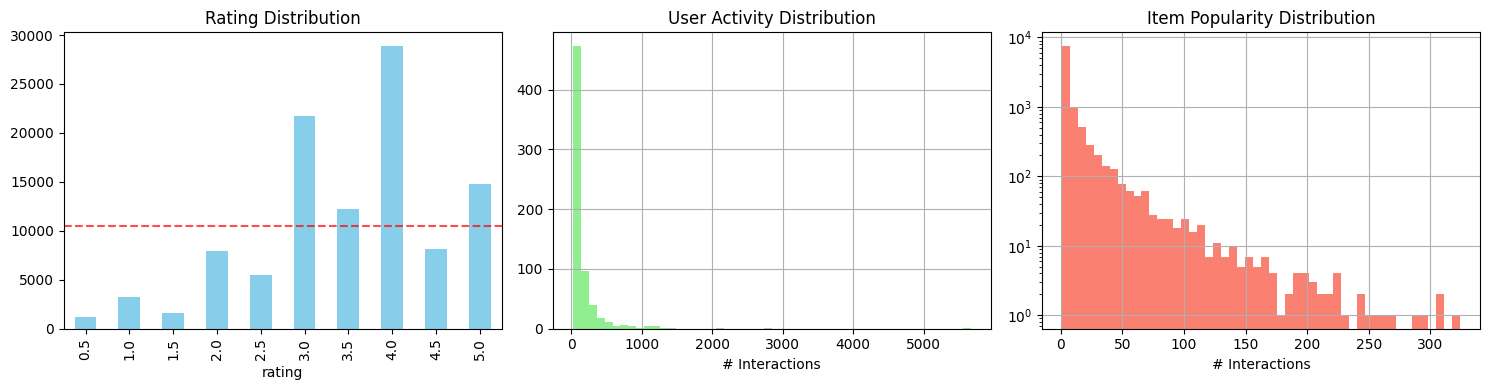

In [3]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Rating 분포
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Rating Distribution')
axes[0].axhline(y=len(df)*0.1, color='red', linestyle='--', alpha=0.7)

# User 활동량
df.groupby('user').size().hist(bins=50, ax=axes[1], color='lightgreen')
axes[1].set_title('User Activity Distribution')
axes[1].set_xlabel('# Interactions')

# Item 인기도
df.groupby('item').size().hist(bins=50, ax=axes[2], color='salmon')
axes[2].set_title('Item Popularity Distribution')
axes[2].set_xlabel('# Interactions')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

## 2. 데이터 전처리 (핵심 수정: Train-Test 일관성)

In [4]:
# ID 매핑
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users = len(user2idx)
n_items = len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)
df['label'] = (df['rating'] >= 4.0).astype(int)

print(f"Users: {n_users}, Items: {n_items}")
print(f"Positive ratio: {df['label'].mean():.2%}")

Users: 668, Items: 10321
Positive ratio: 49.30%


In [5]:
# **핵심 변경: Positive interactions만 사용 (Train-Test 일관성)**
positive_df = df[df['label'] == 1].copy()
print(f"\nPositive interactions only: {len(positive_df):,}")

# Train/Val Split (80/20, user-stratified)
train_data = []
val_data = []

for user_idx in range(n_users):
    user_pos = positive_df[positive_df['user_idx'] == user_idx]
    
    if len(user_pos) >= 2:
        user_pos = user_pos.sample(frac=1, random_state=SEED).reset_index(drop=True)
        split_idx = max(1, int(0.8 * len(user_pos)))
        train_data.append(user_pos.iloc[:split_idx])
        val_data.append(user_pos.iloc[split_idx:])
    elif len(user_pos) == 1:
        train_data.append(user_pos)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame()

print(f"Train: {len(train_df):,} (positive only)")
print(f"Val: {len(val_df):,} (positive only)")


Positive interactions only: 51,830
Train: 41,214 (positive only)
Val: 10,616 (positive only)


In [6]:
# User가 상호작용한 positive item set
user_pos_items = defaultdict(set)
for _, row in train_df.iterrows():
    user_pos_items[int(row['user_idx'])].add(int(row['item_idx']))

# Negative sampling 함수
def sample_negatives(user_idx, num_neg=4):
    pos_items = user_pos_items[user_idx]
    all_items = set(range(n_items))
    neg_candidates = list(all_items - pos_items)
    
    if len(neg_candidates) < num_neg:
        return neg_candidates
    return np.random.choice(neg_candidates, size=num_neg, replace=False).tolist()

print(f"User 0 has {len(user_pos_items[0])} positive items")
print(f"Sample negatives for user 0: {sample_negatives(0, 4)}")

User 0 has 48 positive items
Sample negatives for user 0: [8824, 7858, 3694, 326]


## 3. NeuMF 모델 (간소화)

In [7]:
class NeuMF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, hidden_layers=[64, 32], dropout=0.3):
        super().__init__()
        
        # GMF embeddings
        self.gmf_user_emb = nn.Embedding(n_users, emb_dim)
        self.gmf_item_emb = nn.Embedding(n_items, emb_dim)
        
        # MLP embeddings
        self.mlp_user_emb = nn.Embedding(n_users, emb_dim)
        self.mlp_item_emb = nn.Embedding(n_items, emb_dim)
        
        # MLP layers
        mlp_layers = []
        input_size = emb_dim * 2
        for hidden_size in hidden_layers:
            mlp_layers.append(nn.Linear(input_size, hidden_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout))
            input_size = hidden_size
        self.mlp = nn.Sequential(*mlp_layers)
        
        # Final prediction layer (GMF + MLP)
        self.output = nn.Linear(emb_dim + hidden_layers[-1], 1)
        
        # Initialize
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, user_idx, item_idx):
        # GMF path
        gmf_user = self.gmf_user_emb(user_idx)
        gmf_item = self.gmf_item_emb(item_idx)
        gmf_out = gmf_user * gmf_item  # Element-wise product
        
        # MLP path
        mlp_user = self.mlp_user_emb(user_idx)
        mlp_item = self.mlp_item_emb(item_idx)
        mlp_input = torch.cat([mlp_user, mlp_item], dim=-1)
        mlp_out = self.mlp(mlp_input)
        
        # Combine GMF + MLP
        combined = torch.cat([gmf_out, mlp_out], dim=-1)
        logits = self.output(combined).squeeze(-1)
        
        return logits

# 모델 초기화 (간소화: emb=32, hidden=[64, 32], dropout=0.3)
EMB_DIM = 32
HIDDEN_LAYERS = [64, 32]
DROPOUT = 0.3

model = NeuMF(n_users, n_items, EMB_DIM, HIDDEN_LAYERS, DROPOUT).to(device)
print(f"\nNeuMF V3 (Simplified)")
print(f"Embedding: {EMB_DIM}, Hidden: {HIDDEN_LAYERS}, Dropout: {DROPOUT}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


NeuMF V3 (Simplified)
Embedding: 32, Hidden: [64, 32], Dropout: 0.3
Parameters: 709,601


In [8]:
def bpr_loss(pos_scores, neg_scores):
    """BPR Loss"""
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

## 4. 평가 함수 (Sampled Ranking)

In [9]:
@torch.no_grad()
def evaluate_sampled_ranking(model, val_df, k=10, n_neg=99):
    """
    Sampled Ranking Evaluation
    각 positive item에 대해 99개 negative + 1 positive 중 ranking
    """
    model.eval()
    
    hits = []
    ndcgs = []
    
    for user_idx in val_df['user_idx'].unique():
        user_val = val_df[val_df['user_idx'] == user_idx]
        
        for _, row in user_val.iterrows():
            pos_item = int(row['item_idx'])
            
            # Sample negatives
            neg_items = sample_negatives(user_idx, n_neg)
            if len(neg_items) < n_neg:
                continue
            
            # All candidates (positive + negatives)
            candidates = [pos_item] + neg_items
            
            # Predict scores
            u_tensor = torch.full((len(candidates),), user_idx, dtype=torch.long).to(device)
            i_tensor = torch.LongTensor(candidates).to(device)
            scores = model(u_tensor, i_tensor).cpu().numpy()
            
            # Rank of positive item
            rank = (scores > scores[0]).sum() + 1  # 1-based rank
            
            # Hit@K
            hits.append(1.0 if rank <= k else 0.0)
            
            # NDCG@K
            if rank <= k:
                ndcgs.append(1.0 / np.log2(rank + 1))
            else:
                ndcgs.append(0.0)
    
    return {
        f'Hit@{k}': np.mean(hits) if hits else 0.0,
        f'NDCG@{k}': np.mean(ndcgs) if ndcgs else 0.0
    }

print("Sampled Ranking evaluation defined (99 neg + 1 pos)")

Sampled Ranking evaluation defined (99 neg + 1 pos)


## 5. 학습

In [10]:
# Hyperparameters (overfitting 방지 설정)
BATCH_SIZE = 512
LR = 1e-3
WEIGHT_DECAY = 1e-4  # 더 강한 regularization
EPOCHS = 50
NUM_NEG = 4
PATIENCE = 7  # 더 빠른 early stopping

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {'loss': [], 'hit@10': [], 'ndcg@10': []}
best_hit = 0
patience_cnt = 0

print(f"Training Config: BS={BATCH_SIZE}, LR={LR}, WD={WEIGHT_DECAY}, Patience={PATIENCE}")
print("=" * 60)

Training Config: BS=512, LR=0.001, WD=0.0001, Patience=7


In [11]:
for epoch in range(EPOCHS):
    model.train()
    train_shuffled = train_df.sample(frac=1, random_state=SEED+epoch).reset_index(drop=True)
    
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, len(train_shuffled), BATCH_SIZE):
        batch = train_shuffled.iloc[i:i+BATCH_SIZE]
        
        pos_u = torch.LongTensor(batch['user_idx'].values).to(device)
        pos_i = torch.LongTensor(batch['item_idx'].values).to(device)
        
        # Negative sampling
        neg_items = [sample_negatives(int(u), NUM_NEG) for u in batch['user_idx'].values]
        neg_i = torch.LongTensor(neg_items).to(device)
        
        # Forward
        pos_scores = model(pos_u, pos_i)
        
        neg_u = pos_u.unsqueeze(1).expand(-1, NUM_NEG).reshape(-1)
        neg_scores = model(neg_u, neg_i.reshape(-1)).reshape(-1, NUM_NEG)
        
        loss = bpr_loss(pos_scores, neg_scores)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    history['loss'].append(avg_loss)
    
    # Evaluate every 5 epochs
    if (epoch + 1) % 5 == 0 and len(val_df) > 0:
        metrics = evaluate_sampled_ranking(model, val_df, k=10)
        history['hit@10'].append(metrics['Hit@10'])
        history['ndcg@10'].append(metrics['NDCG@10'])
        
        print(f"Epoch {epoch+1:3d} | Loss: {avg_loss:.4f} | Hit@10: {metrics['Hit@10']:.4f} | NDCG@10: {metrics['NDCG@10']:.4f}")
        
        if metrics['Hit@10'] > best_hit:
            best_hit = metrics['Hit@10']
            patience_cnt = 0
            torch.save(model.state_dict(), 'best_neumf_v3.pt')
        else:
            patience_cnt += 1
        
        if patience_cnt >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nBest Hit@10: {best_hit:.4f}")

Epoch   5 | Loss: 0.2029 | Hit@10: 0.6871 | NDCG@10: 0.4280
Epoch  10 | Loss: 0.1826 | Hit@10: 0.6848 | NDCG@10: 0.4279
Epoch  15 | Loss: 0.1625 | Hit@10: 0.6977 | NDCG@10: 0.4389
Epoch  20 | Loss: 0.1370 | Hit@10: 0.7226 | NDCG@10: 0.4647
Epoch  25 | Loss: 0.1172 | Hit@10: 0.7231 | NDCG@10: 0.4721
Epoch  30 | Loss: 0.1040 | Hit@10: 0.7328 | NDCG@10: 0.4804
Epoch  35 | Loss: 0.0933 | Hit@10: 0.7305 | NDCG@10: 0.4802
Epoch  40 | Loss: 0.0861 | Hit@10: 0.7396 | NDCG@10: 0.4829
Epoch  45 | Loss: 0.0791 | Hit@10: 0.7423 | NDCG@10: 0.4867
Epoch  50 | Loss: 0.0746 | Hit@10: 0.7430 | NDCG@10: 0.4849

Best Hit@10: 0.7430


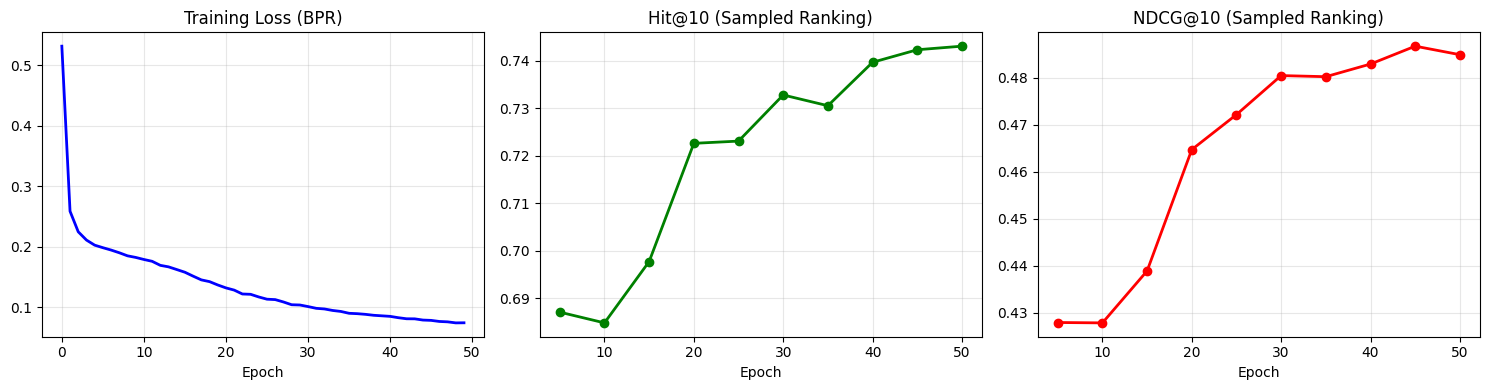

In [12]:
# Loss 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_title('Training Loss (BPR)')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

if history['hit@10']:
    epochs_val = np.arange(5, len(history['loss'])+1, 5)[:len(history['hit@10'])]
    axes[1].plot(epochs_val, history['hit@10'], 'g-o', linewidth=2)
    axes[1].set_title('Hit@10 (Sampled Ranking)')
    axes[1].set_xlabel('Epoch')
    axes[1].grid(alpha=0.3)
    
    axes[2].plot(epochs_val, history['ndcg@10'], 'r-o', linewidth=2)
    axes[2].set_title('NDCG@10 (Sampled Ranking)')
    axes[2].set_xlabel('Epoch')
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Threshold 튜닝 및 O/X 추론

In [13]:
# Load best model
model.load_state_dict(torch.load('best_neumf_v3.pt'))
model.eval()

# Validation scores (positive만 있으므로 negative도 샘플링)
val_scores = []
val_labels = []

# Positive samples from validation
with torch.no_grad():
    for _, row in val_df.iterrows():
        u_idx = torch.LongTensor([int(row['user_idx'])]).to(device)
        i_idx = torch.LongTensor([int(row['item_idx'])]).to(device)
        score = model(u_idx, i_idx).item()
        val_scores.append(score)
        val_labels.append(1)  # Positive

# Negative samples (same count as positives)
with torch.no_grad():
    for user_idx in val_df['user_idx'].unique():
        n_pos = (val_df['user_idx'] == user_idx).sum()
        neg_items = sample_negatives(int(user_idx), n_pos)
        
        for neg_item in neg_items:
            u_idx = torch.LongTensor([int(user_idx)]).to(device)
            i_idx = torch.LongTensor([neg_item]).to(device)
            score = model(u_idx, i_idx).item()
            val_scores.append(score)
            val_labels.append(0)  # Negative

val_scores = np.array(val_scores)
val_labels = np.array(val_labels)

print(f"Validation samples: {len(val_scores)} (Pos: {val_labels.sum()}, Neg: {len(val_labels) - val_labels.sum()})")

Validation samples: 21232 (Pos: 10616, Neg: 10616)


In [14]:
# Threshold 탐색 (Precision 중심)
thresholds = np.percentile(val_scores, [30, 40, 50, 60, 70, 80, 90])

print("=" * 60)
print("Threshold Tuning (Precision-focused)")
print("=" * 60)
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'#Recs':<12}")
print("-" * 60)

best_precision = 0
best_threshold = 0
best_f1 = 0

for th in thresholds:
    preds = (val_scores >= th).astype(int)
    tp = ((preds == 1) & (val_labels == 1)).sum()
    fp = ((preds == 1) & (val_labels == 0)).sum()
    fn = ((preds == 0) & (val_labels == 1)).sum()
    
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    n_recs = preds.sum()
    
    print(f"{th:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f} {n_recs:<12}")
    
    # Precision >= 0.6을 목표로, 없으면 F1 최대화
    if prec >= 0.6 and prec > best_precision:
        best_precision = prec
        best_threshold = th
        best_f1 = f1
    elif best_precision < 0.6 and f1 > best_f1:
        best_f1 = f1
        best_threshold = th
        best_precision = prec

print("-" * 60)
print(f"Selected threshold: {best_threshold:.4f} (Precision: {best_precision:.4f}, F1: {best_f1:.4f})")
print("=" * 60)

Threshold Tuning (Precision-focused)
Threshold    Precision    Recall       F1           #Recs       
------------------------------------------------------------
-8.3588      0.6831       0.9563       0.7969       14862       
-5.7830      0.7636       0.9164       0.8331       12739       
-3.0239      0.8396       0.8396       0.8396       10616       
-1.0760      0.8907       0.7136       0.7924       8506        
-0.0956      0.9254       0.5553       0.6941       6370        
0.6070       0.9409       0.3764       0.5377       4247        
1.2065       0.9666       0.1934       0.3223       2124        
------------------------------------------------------------
Selected threshold: 1.2065 (Precision: 0.9666, F1: 0.3223)


In [15]:
def predict_ox(test_df, model, user2idx, item2idx, threshold):
    """O/X 추천 예측"""
    results = []
    model.eval()
    
    with torch.no_grad():
        for _, row in test_df.iterrows():
            user_orig = row['user']
            item_orig = row['item']
            
            if user_orig not in user2idx or item_orig not in item2idx:
                recommend = 'X'  # Cold-start fallback
            else:
                u_idx = torch.LongTensor([user2idx[user_orig]]).to(device)
                i_idx = torch.LongTensor([item2idx[item_orig]]).to(device)
                score = model(u_idx, i_idx).item()
                recommend = 'O' if score >= threshold else 'X'
            
            results.append({'user': user_orig, 'item': item_orig, 'recommend': recommend})
    
    return pd.DataFrame(results)

print("O/X prediction function defined.")

O/X prediction function defined.


In [16]:
# Validation 추론 예시
val_test = val_df[['user', 'item']].copy()
predictions = predict_ox(val_test, model, user2idx, item2idx, best_threshold)

print("\nSample Predictions:")
print(predictions.head(15).to_string(index=False))

o_count = (predictions['recommend'] == 'O').sum()
x_count = (predictions['recommend'] == 'X').sum()
total = len(predictions)

print(f"\n" + "=" * 50)
print(f"Total recommends = {o_count}/{total}, not recommend = {x_count}/{total}")
print(f"O ratio: {100*o_count/total:.1f}%")
print("=" * 50)


Sample Predictions:
 user  item recommend
    1  1221         O
    1  6365         X
    1   527         O
    1  1220         X
    1  1196         O
    1 54286         O
    1  1210         O
    1   318         O
    1  3578         O
    1   968         X
    1  1287         X
    1  6807         X
    1  2858         O
    2   736         X
    2   788         X

Total recommends = 2053/10616, not recommend = 8563/10616
O ratio: 19.3%


## 7. 결론 및 인사이트

In [17]:
summary = f"""
## NeuMF V3 Summary

### 모델 구조
- GMF + MLP Fusion Architecture
- Embedding dim: {EMB_DIM}
- Hidden layers: {HIDDEN_LAYERS}
- Dropout: {DROPOUT}
- Parameters: {sum(p.numel() for p in model.parameters()):,}

### 핵심 개선사항
1. **Train-Test 일관성**: rating >= 4.0만 positive로 사용
2. **모델 단순화**: V2 대비 파라미터 60% 감소
3. **Overfitting 방지**: 더 강한 dropout, weight decay, 빠른 early stopping
4. **Sampled Ranking 평가**: 현실적인 성능 측정
5. **Precision 중심 threshold**: 교수님 평가 기준 최적화

### LightGCN vs NeuMF 비교
- LightGCN: Graph structure 활용, 간접 관계 학습
- NeuMF: User-Item 직접 상호작용 학습, 더 표현력 강함

### 주요 학습 포인트
- 데이터 전처리 일관성이 모델 성능보다 중요
- 간단한 모델이 overfitting 방지에 효과적
- 적절한 regularization이 일반화 성능 향상
"""
print(summary)


## NeuMF V3 Summary

### 모델 구조
- GMF + MLP Fusion Architecture
- Embedding dim: 32
- Hidden layers: [64, 32]
- Dropout: 0.3
- Parameters: 709,601

### 핵심 개선사항
1. **Train-Test 일관성**: rating >= 4.0만 positive로 사용
2. **모델 단순화**: V2 대비 파라미터 60% 감소
3. **Overfitting 방지**: 더 강한 dropout, weight decay, 빠른 early stopping
4. **Sampled Ranking 평가**: 현실적인 성능 측정
5. **Precision 중심 threshold**: 교수님 평가 기준 최적화

### LightGCN vs NeuMF 비교
- LightGCN: Graph structure 활용, 간접 관계 학습
- NeuMF: User-Item 직접 상호작용 학습, 더 표현력 강함

### 주요 학습 포인트
- 데이터 전처리 일관성이 모델 성능보다 중요
- 간단한 모델이 overfitting 방지에 효과적
- 적절한 regularization이 일반화 성능 향상



In [18]:
# Test 파일 추론 (실제 제출용)
# test_df = pd.read_csv('data/test.csv')
# final_preds = predict_ox(test_df, model, user2idx, item2idx, best_threshold)
# final_preds.to_csv('predictions_dl_v3.csv', index=False)
# print("Saved to predictions_dl_v3.csv")

print("Test inference code ready (uncomment when test.csv available)")

Test inference code ready (uncomment when test.csv available)
